In [2]:
import numpy as np
from scipy import stats


def quantile_norm(X):
    """Normalize the columns of X to each have the same distribution.

    Given an expression matrix (microarray data, read counts, etc) of M genes
    by N samples, quantile normalization ensures all samples have the same
    spread of data (by construction).

    The data across each row are averaged to obtain an average column. Each
    column quantile is replaced with the corresponding quantile of the average
    column.

    Parameters
    ----------
    X : 2D array of float, shape (M, N)
        The input data, with M rows (genes/features) and N columns (samples).

    Returns
    -------
    Xn : 2D array of float, shape (M, N)
        The normalized data.
    """
    # compute the quantiles
    quantiles = np.mean(np.sort(X, axis=0), axis=1)

    # compute the column-wise ranks. Each observation is replaced with its
    # rank in that column: the smallest observation is replaced by 1, the
    # second-smallest by 2, ..., and the largest by M, the number of rows.
    ranks = np.apply_along_axis(stats.rankdata, 0, X)

    # convert ranks to integer indices from 0 to M-1
    rank_indices = ranks.astype(int) - 1

    # index the quantiles for each rank with the ranks matrix
    Xn = quantiles[rank_indices]

    return Xn

In [3]:
def quantile_norm_log(X):
    logX = np.log(X + 1)
    logXn = quantile_norm(logX)
    return logXn

In [4]:
import numpy as np
import pandas as pd

# Import TCGA melanoma data
filename = '../data/counts.txt'
data_table = pd.read_csv(filename, index_col=0)  # Parse file with pandas

print(data_table.iloc[:5, :5])

       00624286-41dd-476f-a63b-d2a5f484bb45  TCGA-FS-A1Z0  TCGA-D9-A3Z1  \
A1BG                                1272.36        452.96        288.06   
A1CF                                   0.00          0.00          0.00   
A2BP1                                  0.00          0.00          0.00   
A2LD1                                164.38        552.43        201.83   
A2ML1                                 27.00          0.00          0.00   

       02c76d24-f1d2-4029-95b4-8be3bda8fdbe  TCGA-EB-A51B  
A1BG                                 400.11        420.46  
A1CF                                   1.00          0.00  
A2BP1                                  0.00          1.00  
A2LD1                                165.12         95.75  
A2ML1                                  0.00          8.00  


In [8]:
# 2D ndarray containing expression counts for each gene in each individual
counts = data_table.values

In [9]:
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../style/elegant.mplstyle')

In [10]:
from scipy import stats

def plot_col_density(data):
    """For each column, produce a density plot over all rows."""

    # Use Gaussian smoothing to estimate the density
    density_per_col = [stats.gaussian_kde(col) for col in data.T]
    x = np.linspace(np.min(data), np.max(data), 100)

    fig, ax = plt.subplots()
    for density in density_per_col:
        ax.plot(x, density(x))
    ax.set_xlabel('Data values (per column)')
    ax.set_ylabel('Density')

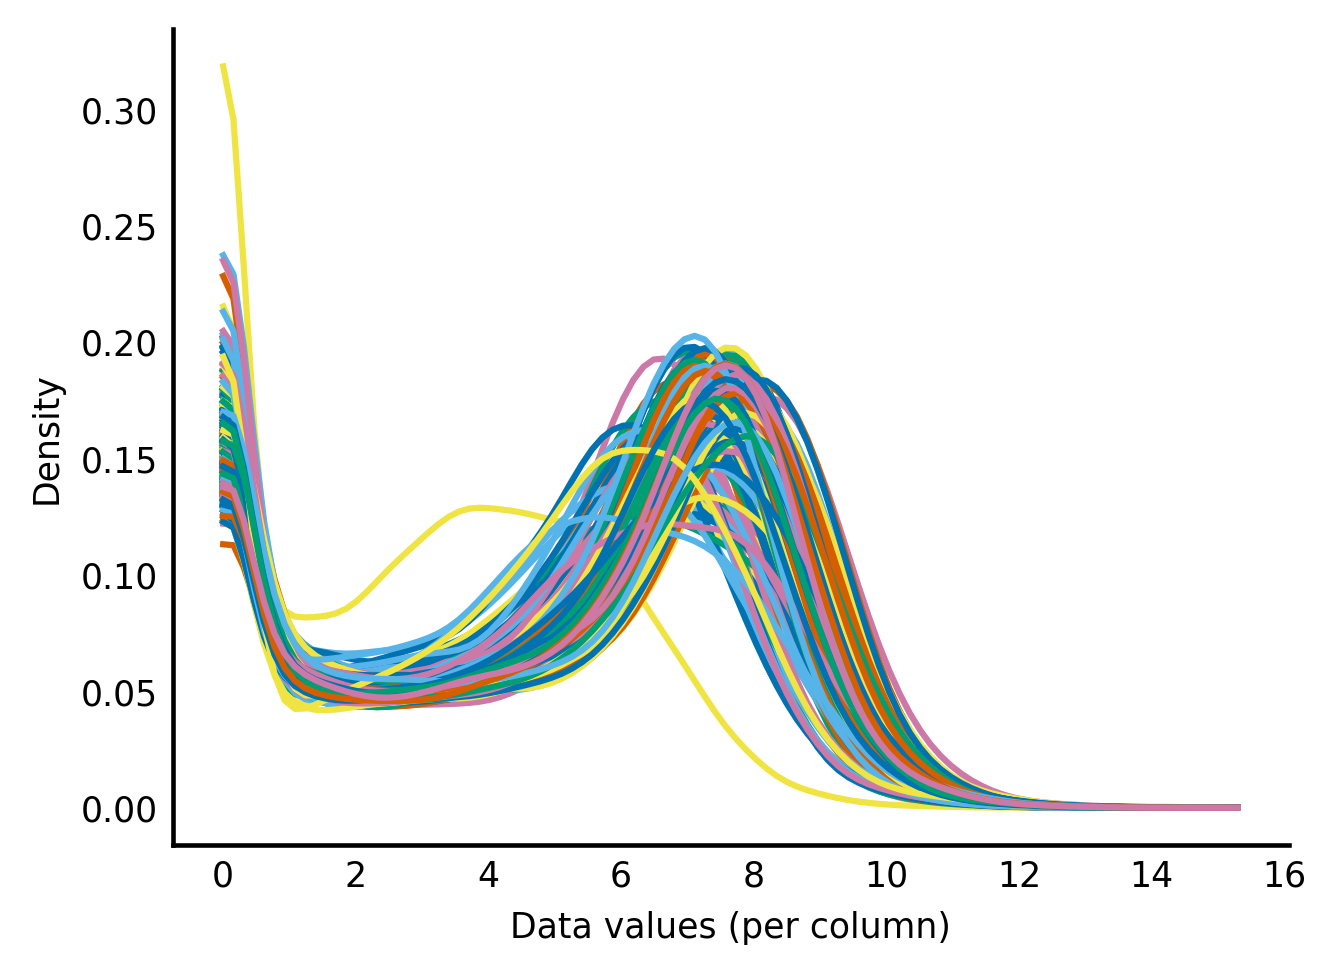

In [11]:
# Before normalization
log_counts = np.log(counts + 1)
plot_col_density(log_counts)

In [12]:
import numpy as np
from scipy import stats

def quantile_norm(X):
    """Normalize the columns of X to each have the same distribution.

    Given an expression matrix (microarray data, read counts, etc.) of M genes
    by N samples, quantile normalization ensures all samples have the same
    spread of data (by construction).

    The data across each row are averaged to obtain an average column. Each
    column quantile is replaced with the corresponding quantile of the average
    column.

    Parameters
    ----------
    X : 2D array of float, shape (M, N)
        The input data, with M rows (genes/features) and N columns (samples).

    Returns
    -------
    Xn : 2D array of float, shape (M, N)
        The normalized data.
    """
    # compute the quantiles
    quantiles = np.mean(np.sort(X, axis=0), axis=1)

    # compute the column-wise ranks. Each observation is replaced with its
    # rank in that column: the smallest observation is replaced by 1, the
    # second-smallest by 2, ..., and the largest by M, the number of rows.
    ranks = np.apply_along_axis(stats.rankdata, 0, X)

    # convert ranks to integer indices from 0 to M-1
    rank_indices = ranks.astype(int) - 1

    # index the quantiles for each rank with the ranks matrix
    Xn = quantiles[rank_indices]

    return Xn


def quantile_norm_log(X):
    logX = np.log(X + 1)
    logXn = quantile_norm(logX)
    return logXn

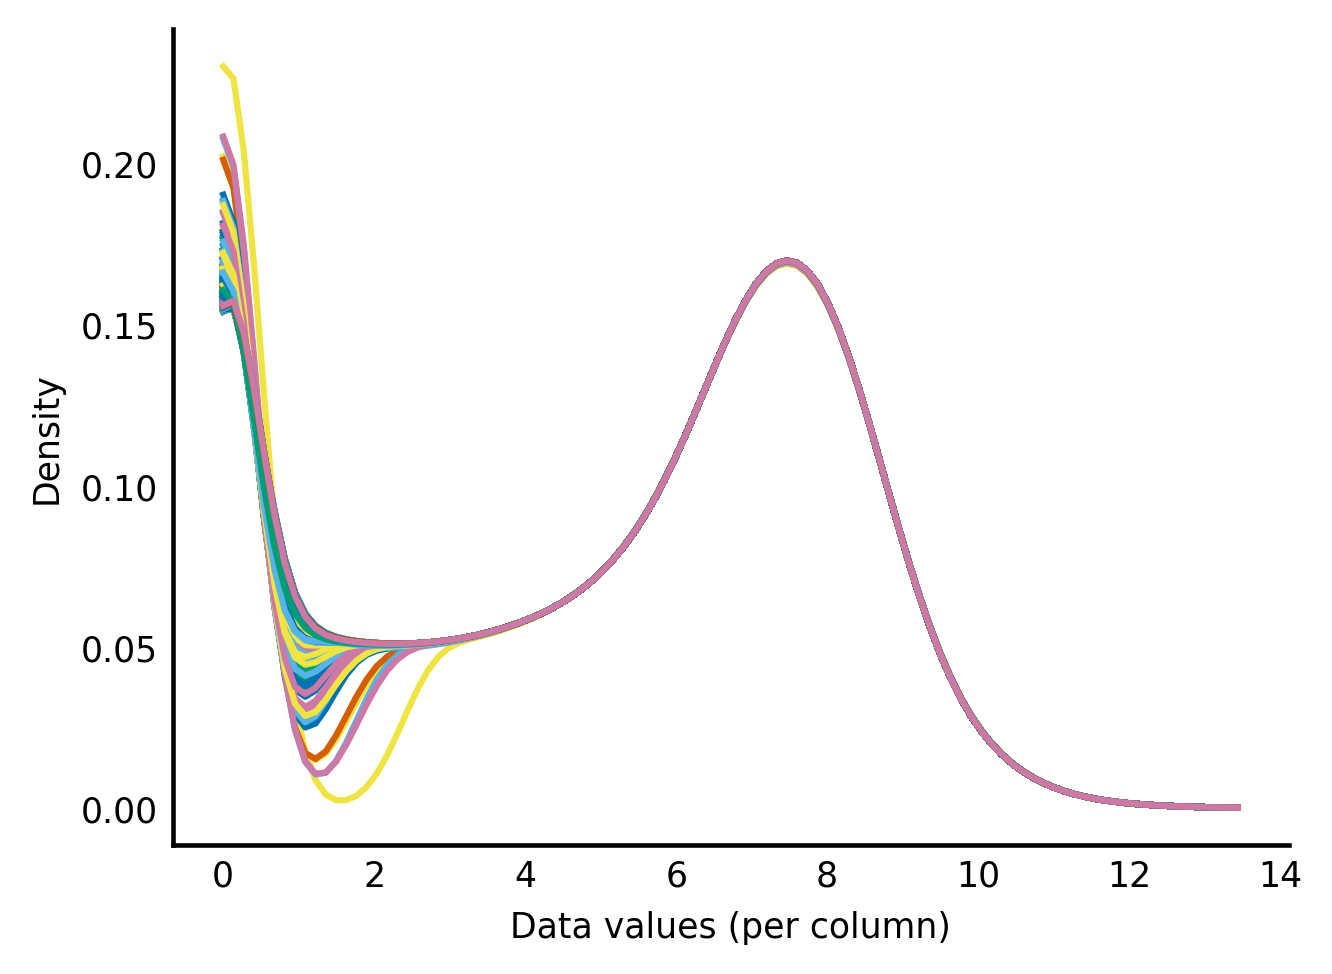

In [13]:
# After normalization
log_counts_normalized = quantile_norm_log(counts)

plot_col_density(log_counts_normalized)

In [14]:
def most_variable_rows(data, *, n=1500):
    """Subset data to the n most variable rows

    In this case, we want the n most variable genes.

    Parameters
    ----------
    data : 2D array of float
        The data to be subset
    n : int, optional
        Number of rows to return.

    Returns
    -------
    variable_data : 2D array of float
        The `n` rows of `data` that exhibit the most variance.
    """
    # compute variance along the columns axis
    rowvar = np.var(data, axis=1)
    # Get sorted indices (ascending order), take the last n
    sort_indices = np.argsort(rowvar)[-n:]
    # use as index for data
    variable_data = data[sort_indices, :]
    return variable_data

In [15]:
from scipy.cluster.hierarchy import linkage


def bicluster(data, linkage_method='average', distance_metric='correlation'):
    """Cluster the rows and the columns of a matrix.

    Parameters
    ----------
    data : 2D ndarray
        The input data to bicluster.
    linkage_method : string, optional
        Method to be passed to `linkage`.
    distance_metric : string, optional
        Distance metric to use for clustering. See the documentation
        for ``scipy.spatial.distance.pdist`` for valid metrics.

    Returns
    -------
    y_rows : linkage matrix
        The clustering of the rows of the input data.
    y_cols : linkage matrix
        The clustering of the cols of the input data.
    """
    y_rows = linkage(data, method=linkage_method, metric=distance_metric)
    y_cols = linkage(data.T, method=linkage_method, metric=distance_metric)
    return y_rows, y_cols

In [16]:
from scipy.cluster.hierarchy import dendrogram, leaves_list


def clear_spines(axes):
    for loc in ['left', 'right', 'top', 'bottom']:
        axes.spines[loc].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])


def plot_bicluster(data, row_linkage, col_linkage,
                   row_nclusters=10, col_nclusters=3):
    """Perform a biclustering, plot a heatmap with dendrograms on each axis.

    Parameters
    ----------
    data : array of float, shape (M, N)
        The input data to bicluster.
    row_linkage : array, shape (M-1, 4)
        The linkage matrix for the rows of `data`.
    col_linkage : array, shape (N-1, 4)
        The linkage matrix for the columns of `data`.
    n_clusters_r, n_clusters_c : int, optional
        Number of clusters for rows and columns.
    """
    fig = plt.figure(figsize=(4.8, 4.8))

    # Compute and plot row-wise dendrogram
    # `add_axes` takes a "rectangle" input to add a subplot to a figure.
    # The figure is considered to have side-length 1 on each side, and its
    # bottom-left corner is at (0, 0).
    # The measurements passed to `add_axes` are the left, bottom, width, and
    # height of the subplot. Thus, to draw the left dendrogram (for the rows),
    # we create a rectangle whose bottom-left corner is at (0.09, 0.1), and
    # measuring 0.2 in width and 0.6 in height.
    ax1 = fig.add_axes([0.09, 0.1, 0.2, 0.6])
    # For a given number of clusters, we can obtain a cut of the linkage
    # tree by looking at the corresponding distance annotation in the linkage
    # matrix.
    threshold_r = (row_linkage[-row_nclusters, 2] +
                   row_linkage[-row_nclusters+1, 2]) / 2
    with plt.rc_context({'lines.linewidth': 0.75}):
        dendrogram(row_linkage, orientation='left',
                   color_threshold=threshold_r, ax=ax1)
    clear_spines(ax1)

    # Compute and plot column-wise dendrogram
    # See notes above for explanation of parameters to `add_axes`
    ax2 = fig.add_axes([0.3, 0.71, 0.6, 0.2])
    threshold_c = (col_linkage[-col_nclusters, 2] +
                   col_linkage[-col_nclusters+1, 2]) / 2
    with plt.rc_context({'lines.linewidth': 0.75}):
        dendrogram(col_linkage, color_threshold=threshold_c, ax=ax2)
    clear_spines(ax2)

    # Plot data heatmap
    ax = fig.add_axes([0.3, 0.1, 0.6, 0.6])

    # Sort data by the dendrogram leaves
    idx_rows = leaves_list(row_linkage)
    data = data[idx_rows, :]
    idx_cols = leaves_list(col_linkage)
    data = data[:, idx_cols]

    im = ax.imshow(data, aspect='auto', origin='lower', cmap='YlGnBu_r')
    clear_spines(ax)

    # Axis labels
    ax.set_xlabel('Samples')
    ax.set_ylabel('Genes', labelpad=125)

    # Plot legend
    axcolor = fig.add_axes([0.91, 0.1, 0.02, 0.6])
    plt.colorbar(im, cax=axcolor)

    # display the plot
    plt.show()

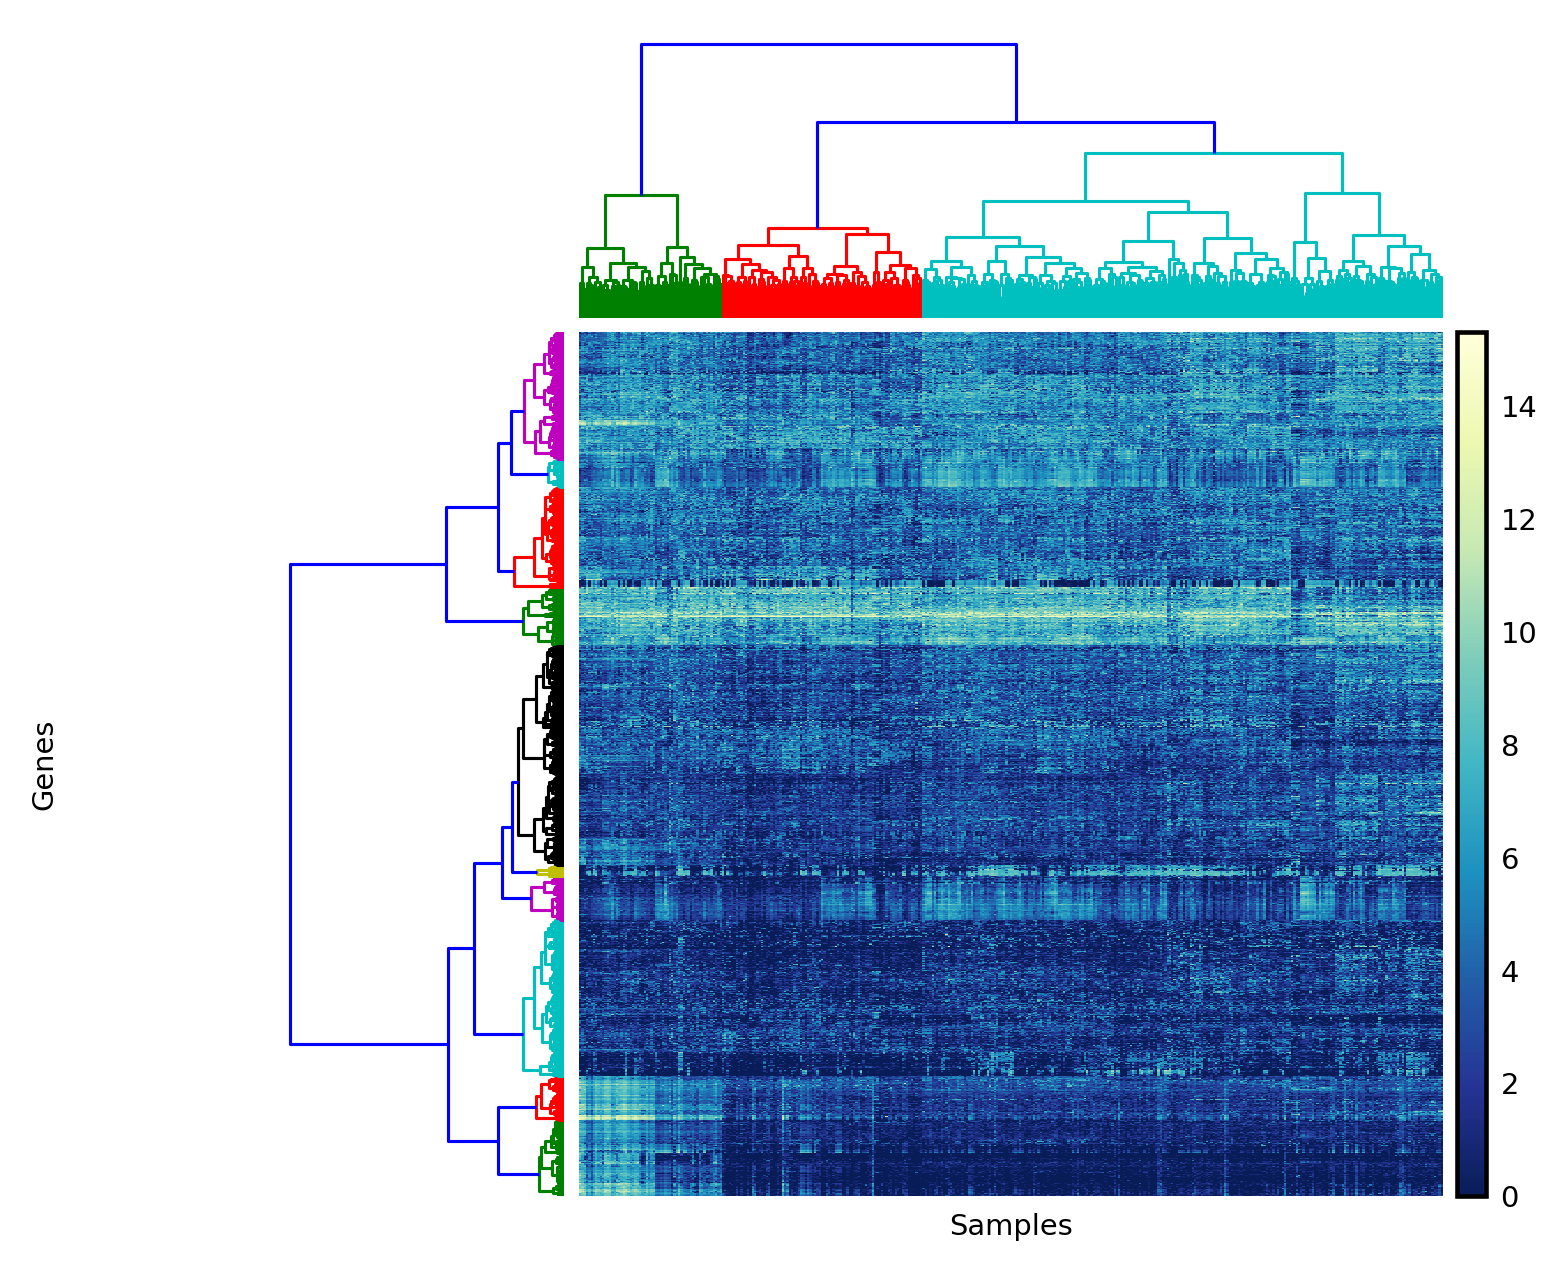

In [18]:
counts_log = np.log(counts + 1)
counts_var = most_variable_rows(counts_log, n=1500)
yr, yc = bicluster(counts_var, linkage_method='ward',
                   distance_metric='euclidean')
with plt.style.context('../style/thinner.mplstyle'):
    plot_bicluster(counts_var, yr, yc)

In [19]:
patients = pd.read_csv('../data/patients.csv', index_col=0)
patients.head()

,UV-signature,original-clusters,melanoma-survival-time,melanoma-dead
TCGA-BF-A1PU,UV signature,keratin,NaN,NaN
TCGA-BF-A1PV,UV signature,keratin,13.0,0.0
TCGA-BF-A1PX,UV signature,keratin,NaN,NaN
TCGA-BF-A1PZ,UV signature,keratin,NaN,NaN
TCGA-BF-A1Q0,not UV,immune,17.0,0.0


In [20]:
def survival_distribution_function(lifetimes, right_censored=None):
    """Return the survival distribution function of a set of lifetimes.

    Parameters
    ----------
    lifetimes : array of float or int
        The observed lifetimes of a population. These must be non-negative.
    right_censored : array of bool, same shape as `lifetimes`
        A value of `True` here indicates that this lifetime was not observed.
        Values of `np.nan` in `lifetimes` are also considered to be
        right-censored.

    Returns
    -------
    sorted_lifetimes : array of float
        The
    sdf : array of float
        Values starting at 1 and progressively decreasing, one level
        for each observation in `lifetimes`.

    Examples
    --------

    In this example, of a population of four, two die at time 1, a
    third dies at time 2, and a final individual dies at an unknown
    time. (Hence, ``np.nan``.)

    >>> lifetimes = np.array([2, 1, 1, np.nan])
    >>> survival_distribution_function(lifetimes)
    (array([ 0.,  1.,  1.,  2.]), array([ 1.  ,  0.75,  0.5 ,  0.25]))
    """
    n_obs = len(lifetimes)
    rc = np.isnan(lifetimes)
    if right_censored is not None:
        rc |= right_censored
    observed = lifetimes[~rc]
    xs = np.concatenate( ([0], np.sort(observed)) )
    ys = np.linspace(1, 0, n_obs + 1)
    ys = ys[:len(xs)]
    return xs, ys

In [21]:
def plot_cluster_survival_curves(clusters, sample_names, patients,
                                 censor=True):
    """Plot the survival data from a set of sample clusters.

    Parameters
    ----------
    clusters : array of int or categorical pd.Series
        The cluster identity of each sample, encoded as a simple int
        or as a pandas categorical variable.
    sample_names : list of string
        The name corresponding to each sample. Must be the same length
        as `clusters`.
    patients : pandas.DataFrame
        The DataFrame containing survival information for each patient.
        The indices of this DataFrame must correspond to the
        `sample_names`. Samples not represented in this list will be
        ignored.
    censor : bool, optional
        If `True`, use `patients['melanoma-dead']` to right-censor the
        survival data.
    """
    fig, ax = plt.subplots()
    if type(clusters) == np.ndarray:
        cluster_ids = np.unique(clusters)
        cluster_names = ['cluster {}'.format(i) for i in cluster_ids]
    elif type(clusters) == pd.Series:
        cluster_ids = clusters.cat.categories
        cluster_names = list(cluster_ids)
    n_clusters = len(cluster_ids)
    for c in cluster_ids:
        clust_samples = np.flatnonzero(clusters == c)
        # discard patients not present in survival data
        clust_samples = [sample_names[i] for i in clust_samples
                         if sample_names[i] in patients.index]
        patient_cluster = patients.loc[clust_samples]
        survival_times = patient_cluster['melanoma-survival-time'].values
        if censor:
            censored = ~patient_cluster['melanoma-dead'].values.astype(bool)
        else:
            censored = None
        stimes, sfracs = survival_distribution_function(survival_times,
                                                        censored)
        ax.plot(stimes / 365, sfracs)

    ax.set_xlabel('survival time (years)')
    ax.set_ylabel('fraction alive')
    ax.legend(cluster_names)

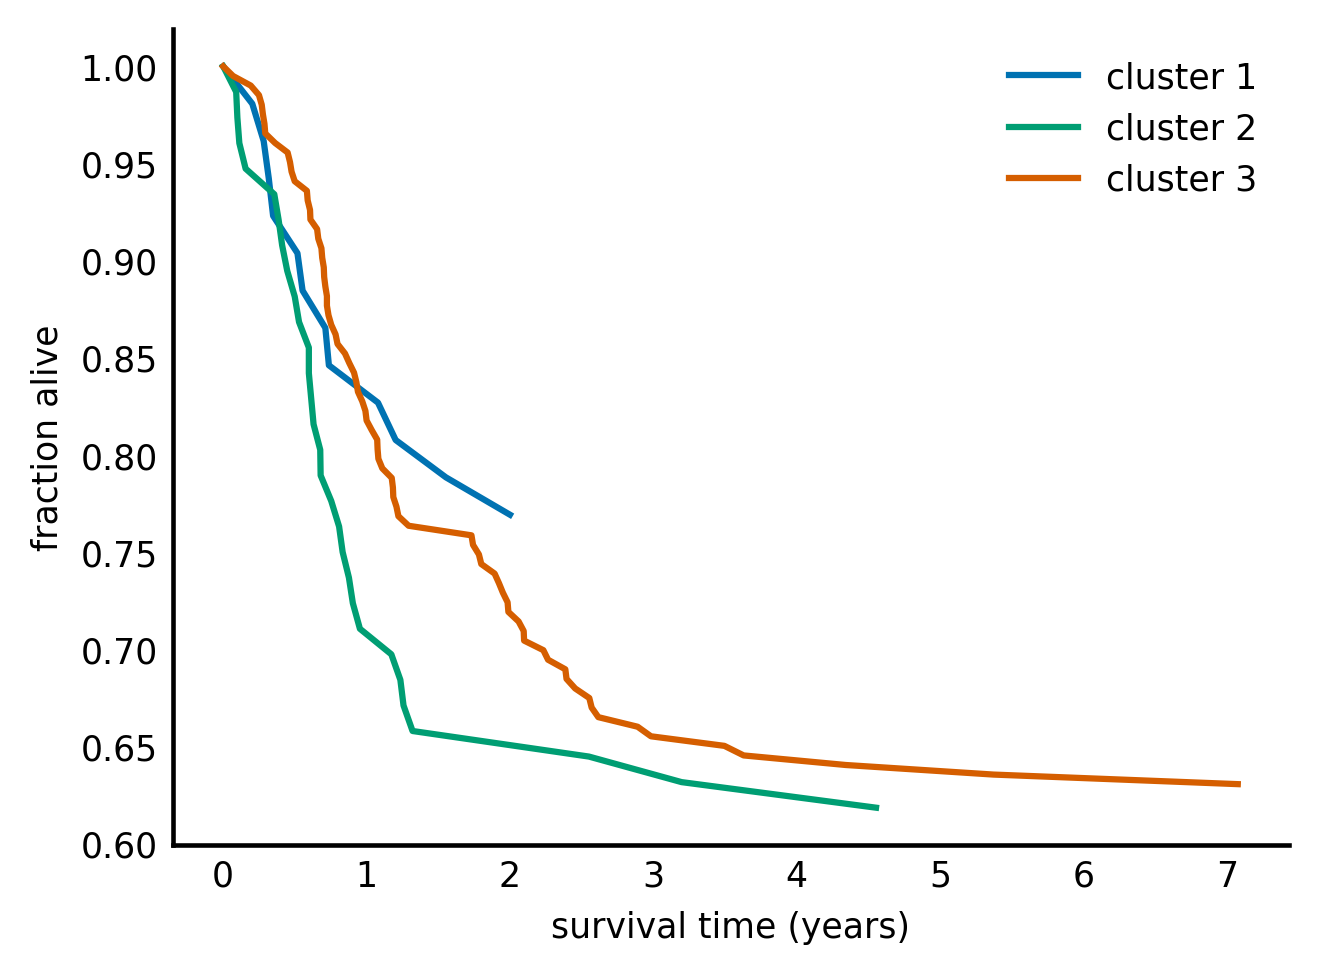

In [22]:
from scipy.cluster.hierarchy import fcluster
n_clusters = 3
threshold_distance = (yc[-n_clusters, 2] + yc[-n_clusters+1, 2]) / 2
clusters = fcluster(yc, threshold_distance, 'distance')

plot_cluster_survival_curves(clusters, data_table.columns, patients)